In [1]:
SOURCE = '../data/caterpillar/caterpillar-tube-pricing/competition_data/'

In [2]:
import pandas as pd
materials = pd.read_csv(SOURCE + 'bill_of_materials.csv')
materials.head()

,tube_assembly_id,component_id_1,quantity_1,component_id_2,quantity_2,component_id_3,quantity_3,component_id_4,quantity_4,component_id_5,quantity_5,component_id_6,quantity_6,component_id_7,quantity_7,component_id_8,quantity_8
0,TA-00001,C-1622,2.0,C-1629,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TA-00002,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TA-00003,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TA-00004,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TA-00005,C-1624,1.0,C-1631,1.0,C-1641,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


| Crosstab | C-1622 | C-1629 | C-1312 | C-1624 | C-1631 | C-1641 | Distinct | Total |
|:--------:|:------:|--------|--------|--------|--------|--------|----------|-------|
| TA-00001 | 2      | 2      | 0      | 0      | 0      | 0      | 2        | 4     |
| TA-00002 | 0      | 0      | 2      | 0      | 0      | 0      | 1        | 2     |
| TA-00003 | 0      | 0      | 2      | 0      | 0      | 0      | 1        | 2     |
| TA-00004 | 0      | 0      | 2      | 0      | 0      | 0      | 1        | 2     |
| TA-00005 | 0      | 0      | 0      | 1      | 1      | 1      | 3        | 3     |

In [3]:
components = pd.read_csv(SOURCE + 'components.csv')
components.describe()

,component_id,name,component_type_id
count,2048,2047,2048
unique,2048,297,29
top,C-1040,FLANGE,OTHER
freq,1,350,1006


In [4]:
components.head()

,component_id,name,component_type_id
0,9999,OTHER,OTHER
1,C-0001,SLEEVE,CP-024
2,C-0002,SLEEVE,CP-024
3,C-0003,SLEEVE-FLARED,CP-024
4,C-0004,NUT,CP-026


In [5]:
import category_encoders as ce
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

def wrangle(X):
    X = X.copy()
    
    # Engineer date features
    X['quote_date'] = pd.to_datetime(X['quote_date'], infer_datetime_format=True)
    X['quote_date_year'] = X['quote_date'].dt.year
    X['quote_date_month'] = X['quote_date'].dt.month
    X = X.drop(columns='quote_date')
    
    # Merge tube data
    tube = pd.read_csv(SOURCE + 'tube.csv')
    X = X.merge(tube, how='left')
    
    # Engineer features from bill_of_materials
    materials = pd.read_csv(SOURCE + 'bill_of_materials.csv')
    
    materials['components_total'] = (materials['quantity_1'].fillna(0) + 
                                     materials['quantity_2'].fillna(0) + 
                                     materials['quantity_3'].fillna(0) + 
                                     materials['quantity_4'].fillna(0) + 
                                     materials['quantity_5'].fillna(0) + 
                                     materials['quantity_6'].fillna(0) + 
                                     materials['quantity_7'].fillna(0) + 
                                     materials['quantity_8'].fillna(0))

    materials['components_distinct'] = (materials['component_id_1'].notnull().astype(int) + 
                                        materials['component_id_2'].notnull().astype(int) + 
                                        materials['component_id_3'].notnull().astype(int) + 
                                        materials['component_id_4'].notnull().astype(int) + 
                                        materials['component_id_5'].notnull().astype(int) + 
                                        materials['component_id_6'].notnull().astype(int) + 
                                        materials['component_id_7'].notnull().astype(int) + 
                                        materials['component_id_8'].notnull().astype(int))
    
    # Merge selected features from bill_of_materials
    # Just use the first component_id, ignore the others for now!
    features = ['tube_assembly_id', 'component_id_1', 'components_total', 'components_distinct']
    X = X.merge(materials[features], how='left')
    
    # Get component_type_id (has lower cardinality than component_id)
    components = pd.read_csv(SOURCE + 'components.csv')
    components = components.rename(columns={'component_id': 'component_id_1'})
    features = ['component_id_1', 'component_type_id']
    X = X.merge(components[features], how='left')
    
    # Count the number of specs for the tube assembly
    specs = pd.read_csv(SOURCE + 'specs.csv')
    specs['specs_total'] = specs.drop(columns=['tube_assembly_id']).count(axis=1)
    features = ['tube_assembly_id', 'specs_total', 'spec1']
    X = X.merge(specs[features], how='left')
    
    # Drop tube_assembly_id because our goal is to predict unknown assemblies
    X = X.drop(columns='tube_assembly_id')
    
    return X


# Read data
trainval = pd.read_csv(SOURCE + 'train_set.csv')
test = pd.read_csv(SOURCE + 'test_set.csv')

# Split into train & validation sets
# All rows for a given tube_assembly_id should go in either train or validation
trainval_tube_assemblies = trainval['tube_assembly_id'].unique()
train_tube_assemblies, val_tube_assemblies = train_test_split(
    trainval_tube_assemblies, random_state=42)
train = trainval[trainval.tube_assembly_id.isin(train_tube_assemblies)]
val = trainval[trainval.tube_assembly_id.isin(val_tube_assemblies)]

# Wrangle train, validation, and test sets
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

# Arrange X matrix and y vector (log-transformed)
target = 'cost'
X_train = train.drop(columns=target)
X_val = val.drop(columns=target)
X_test = test.drop(columns='id')
y_train = train[target]
y_val = val[target]
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

In [6]:
# Make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit
pipeline.fit(X_train, y_train_log)

# Validate
y_pred_log = pipeline.predict(X_val)
print('Validation Error', rmse(y_val_log, y_pred_log))

# Predict
def generate_submission(estimator, X_test, filename):
    y_pred_log = estimator.predict(X_test)
    y_pred = np.expm1(y_pred_log)  # Convert from log-dollars to dollars
    submission = pd.read_csv(SOURCE + '../sample_submission.csv')
    submission['cost'] = y_pred
    submission.to_csv(filename, index=False)
    
generate_submission(pipeline, X_test, 'submission-03.csv')

Validation Error 0.2968940527141928


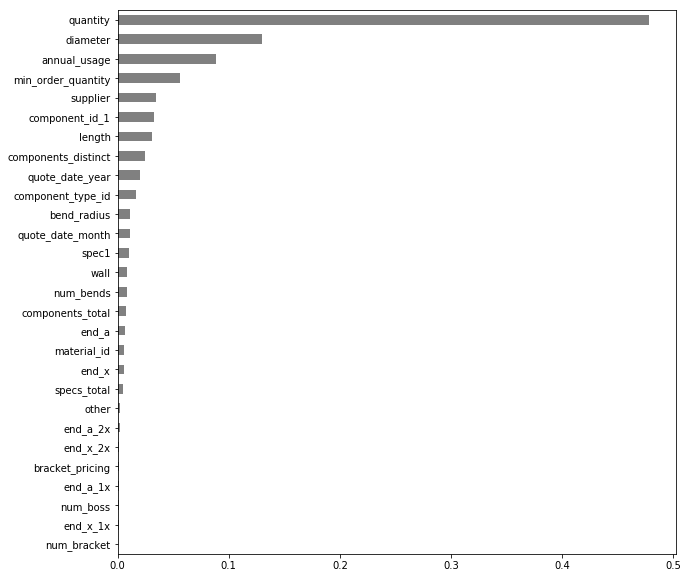

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
rf = pipeline.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color='grey');

## Use xgboost for gradient boosting

#### [XGBoost Python API Reference: Scikit-Learn API](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)

In [8]:
from xgboost import XGBRegressor

# Make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=1000, n_job=-1)
)

# Fit
pipeline.fit(X_train, y_train_log)

# Validate
y_pred_log = pipeline.predict(X_val)
print('Validation Error', rmse(y_val_log, y_pred_log))

/Users/ericchiyembekeza/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:39:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation Error 0.2700581596577784


In [9]:
generate_submission(pipeline, X_test, 'submission_xgboost_1.csv')

In [10]:
import category_encoders as ce

encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

In [11]:
eval_set = [
    (X_train_encoded, y_train_log),
    (X_val_encoded, y_val_log)
]

In [12]:
import xgboost
model = XGBRegressor(n_estimators=1000, n_job=-1)

model.fit(X_train_encoded, 
          y_train_log, 
          eval_set=eval_set,
          eval_metric='rmse',
          early_stopping_rounds=10
         )

/Users/ericchiyembekeza/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:40:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.71924	validation_1-rmse:1.70846
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.56516	validation_1-rmse:1.55498
[2]	validation_0-rmse:1.42779	validation_1-rmse:1.41846
[3]	validation_0-rmse:1.30338	validation_1-rmse:1.29429
[4]	validation_0-rmse:1.19168	validation_1-rmse:1.18295
[5]	validation_0-rmse:1.09322	validation_1-rmse:1.08553
[6]	validation_0-rmse:1.0052	validation_1-rmse:0.997831
[7]	validation_0-rmse:0.927625	validation_1-rmse:0.922044
[8]	validation_0-rmse:0.859914	validation_1-rmse:0.85702
[9]	validation_0-rmse:0.799929	validation_1-rmse:0.798434
[10]	validation_0-rmse:0.747475	validation_1-rmse:0.747741
[11]	validation_0-rmse:0.700331	validation_1-rmse:0.700593
[12]	validation_0-rmse:0.660556	validation

[135]	validation_0-rmse:0.292511	validation_1-rmse:0.321289
[136]	validation_0-rmse:0.29203	validation_1-rmse:0.32076
[137]	validation_0-rmse:0.291661	validation_1-rmse:0.320421
[138]	validation_0-rmse:0.291383	validation_1-rmse:0.320185
[139]	validation_0-rmse:0.290948	validation_1-rmse:0.319794
[140]	validation_0-rmse:0.290569	validation_1-rmse:0.319702
[141]	validation_0-rmse:0.290107	validation_1-rmse:0.319278
[142]	validation_0-rmse:0.289774	validation_1-rmse:0.31916
[143]	validation_0-rmse:0.289504	validation_1-rmse:0.319006
[144]	validation_0-rmse:0.28927	validation_1-rmse:0.318959
[145]	validation_0-rmse:0.289149	validation_1-rmse:0.318867
[146]	validation_0-rmse:0.288531	validation_1-rmse:0.318088
[147]	validation_0-rmse:0.288218	validation_1-rmse:0.317771
[148]	validation_0-rmse:0.288105	validation_1-rmse:0.317679
[149]	validation_0-rmse:0.287501	validation_1-rmse:0.317112
[150]	validation_0-rmse:0.287182	validation_1-rmse:0.316784
[151]	validation_0-rmse:0.286461	validation_

[273]	validation_0-rmse:0.25758	validation_1-rmse:0.297484
[274]	validation_0-rmse:0.257402	validation_1-rmse:0.297312
[275]	validation_0-rmse:0.257198	validation_1-rmse:0.297147
[276]	validation_0-rmse:0.257034	validation_1-rmse:0.297112
[277]	validation_0-rmse:0.256892	validation_1-rmse:0.296978
[278]	validation_0-rmse:0.256618	validation_1-rmse:0.296333
[279]	validation_0-rmse:0.256531	validation_1-rmse:0.296292
[280]	validation_0-rmse:0.256382	validation_1-rmse:0.296332
[281]	validation_0-rmse:0.256219	validation_1-rmse:0.296277
[282]	validation_0-rmse:0.256132	validation_1-rmse:0.296184
[283]	validation_0-rmse:0.256076	validation_1-rmse:0.296163
[284]	validation_0-rmse:0.255978	validation_1-rmse:0.296221
[285]	validation_0-rmse:0.255853	validation_1-rmse:0.296097
[286]	validation_0-rmse:0.255583	validation_1-rmse:0.295978
[287]	validation_0-rmse:0.255388	validation_1-rmse:0.295725
[288]	validation_0-rmse:0.255235	validation_1-rmse:0.295605
[289]	validation_0-rmse:0.255167	validati

[410]	validation_0-rmse:0.23832	validation_1-rmse:0.284886
[411]	validation_0-rmse:0.238178	validation_1-rmse:0.284805
[412]	validation_0-rmse:0.23806	validation_1-rmse:0.284868
[413]	validation_0-rmse:0.237916	validation_1-rmse:0.28471
[414]	validation_0-rmse:0.237862	validation_1-rmse:0.284685
[415]	validation_0-rmse:0.237781	validation_1-rmse:0.284706
[416]	validation_0-rmse:0.237747	validation_1-rmse:0.284699
[417]	validation_0-rmse:0.237609	validation_1-rmse:0.284644
[418]	validation_0-rmse:0.237596	validation_1-rmse:0.284646
[419]	validation_0-rmse:0.237546	validation_1-rmse:0.284644
[420]	validation_0-rmse:0.237506	validation_1-rmse:0.284541
[421]	validation_0-rmse:0.237427	validation_1-rmse:0.284535
[422]	validation_0-rmse:0.237308	validation_1-rmse:0.284584
[423]	validation_0-rmse:0.237182	validation_1-rmse:0.284557
[424]	validation_0-rmse:0.237119	validation_1-rmse:0.284635
[425]	validation_0-rmse:0.237017	validation_1-rmse:0.28438
[426]	validation_0-rmse:0.236972	validation_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_job=-1, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

(0.2, 0.4)

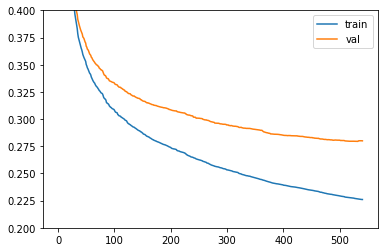

In [13]:
results = model.evals_result()

train_rmse = results['validation_0']['rmse']
val_rmse = results['validation_1']['rmse']

epochs = range(0, len(train_rmse))

plt.plot(epochs, train_rmse, label='train')
plt.plot(epochs, val_rmse, label='val')
plt.legend();
plt.ylim(0.2, 0.4)

In [14]:
from catboost import CatBoostRegressor

# Make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    CatBoostRegressor(learning_rate=0.3)
)

# Fit
pipeline.fit(X_train, y_train_log)

# Validate
y_pred_log = pipeline.predict(X_val)
print('Validation Error', rmse(y_val_log, y_pred_log))

0:	learn: 1.7063512	total: 174ms	remaining: 2m 53s
1:	learn: 1.2756902	total: 202ms	remaining: 1m 40s
2:	learn: 0.9694022	total: 232ms	remaining: 1m 17s
3:	learn: 0.7520570	total: 263ms	remaining: 1m 5s
4:	learn: 0.6097303	total: 281ms	remaining: 55.8s
5:	learn: 0.5294796	total: 313ms	remaining: 51.9s
6:	learn: 0.4657627	total: 331ms	remaining: 46.9s
7:	learn: 0.4252448	total: 351ms	remaining: 43.5s
8:	learn: 0.3983808	total: 463ms	remaining: 50.9s
9:	learn: 0.3842124	total: 481ms	remaining: 47.6s
10:	learn: 0.3694200	total: 513ms	remaining: 46.1s
11:	learn: 0.3633047	total: 534ms	remaining: 44s
12:	learn: 0.3547063	total: 564ms	remaining: 42.8s
13:	learn: 0.3488532	total: 595ms	remaining: 41.9s
14:	learn: 0.3437360	total: 615ms	remaining: 40.4s
15:	learn: 0.3423312	total: 633ms	remaining: 38.9s
16:	learn: 0.3399380	total: 694ms	remaining: 40.2s
17:	learn: 0.3372858	total: 727ms	remaining: 39.6s
18:	learn: 0.3322560	total: 760ms	remaining: 39.3s
19:	learn: 0.3303295	total: 780ms	remain

166:	learn: 0.2418134	total: 5.86s	remaining: 29.2s
167:	learn: 0.2393780	total: 5.89s	remaining: 29.2s
168:	learn: 0.2385309	total: 5.91s	remaining: 29.1s
169:	learn: 0.2385285	total: 5.94s	remaining: 29s
170:	learn: 0.2385245	total: 5.96s	remaining: 28.9s
171:	learn: 0.2377194	total: 5.98s	remaining: 28.8s
172:	learn: 0.2366601	total: 6s	remaining: 28.7s
173:	learn: 0.2366303	total: 6.03s	remaining: 28.6s
174:	learn: 0.2365849	total: 6.05s	remaining: 28.5s
175:	learn: 0.2361720	total: 6.09s	remaining: 28.5s
176:	learn: 0.2356582	total: 6.11s	remaining: 28.4s
177:	learn: 0.2356543	total: 6.13s	remaining: 28.3s
178:	learn: 0.2356503	total: 6.14s	remaining: 28.2s
179:	learn: 0.2356497	total: 6.17s	remaining: 28.1s
180:	learn: 0.2356492	total: 6.19s	remaining: 28s
181:	learn: 0.2356471	total: 6.22s	remaining: 27.9s
182:	learn: 0.2356453	total: 6.23s	remaining: 27.8s
183:	learn: 0.2356434	total: 6.25s	remaining: 27.7s
184:	learn: 0.2356415	total: 6.27s	remaining: 27.6s
185:	learn: 0.23564

331:	learn: 0.2226269	total: 12.7s	remaining: 25.5s
332:	learn: 0.2226264	total: 12.7s	remaining: 25.5s
333:	learn: 0.2226239	total: 12.7s	remaining: 25.4s
334:	learn: 0.2225093	total: 12.8s	remaining: 25.4s
335:	learn: 0.2224568	total: 12.8s	remaining: 25.3s
336:	learn: 0.2224523	total: 12.8s	remaining: 25.2s
337:	learn: 0.2224484	total: 12.8s	remaining: 25.1s
338:	learn: 0.2218081	total: 12.9s	remaining: 25.1s
339:	learn: 0.2218047	total: 12.9s	remaining: 25.1s
340:	learn: 0.2218045	total: 12.9s	remaining: 25s
341:	learn: 0.2218037	total: 13s	remaining: 24.9s
342:	learn: 0.2209088	total: 13s	remaining: 24.9s
343:	learn: 0.2209014	total: 13s	remaining: 24.8s
344:	learn: 0.2209012	total: 13s	remaining: 24.7s
345:	learn: 0.2209010	total: 13.1s	remaining: 24.7s
346:	learn: 0.2209010	total: 13.1s	remaining: 24.6s
347:	learn: 0.2209009	total: 13.1s	remaining: 24.5s
348:	learn: 0.2208844	total: 13.1s	remaining: 24.5s
349:	learn: 0.2208843	total: 13.2s	remaining: 24.4s
350:	learn: 0.2208841	

493:	learn: 0.2097907	total: 16.6s	remaining: 17s
494:	learn: 0.2095645	total: 16.6s	remaining: 17s
495:	learn: 0.2095642	total: 16.7s	remaining: 16.9s
496:	learn: 0.2095640	total: 16.7s	remaining: 16.9s
497:	learn: 0.2095574	total: 16.7s	remaining: 16.8s
498:	learn: 0.2095572	total: 16.7s	remaining: 16.8s
499:	learn: 0.2095397	total: 16.7s	remaining: 16.7s
500:	learn: 0.2095392	total: 16.8s	remaining: 16.7s
501:	learn: 0.2095385	total: 16.8s	remaining: 16.7s
502:	learn: 0.2095381	total: 16.8s	remaining: 16.6s
503:	learn: 0.2095377	total: 16.8s	remaining: 16.6s
504:	learn: 0.2095374	total: 16.9s	remaining: 16.5s
505:	learn: 0.2092875	total: 16.9s	remaining: 16.5s
506:	learn: 0.2092873	total: 16.9s	remaining: 16.4s
507:	learn: 0.2092614	total: 16.9s	remaining: 16.4s
508:	learn: 0.2092613	total: 16.9s	remaining: 16.3s
509:	learn: 0.2086848	total: 17s	remaining: 16.3s
510:	learn: 0.2086723	total: 17s	remaining: 16.3s
511:	learn: 0.2086667	total: 17s	remaining: 16.2s
512:	learn: 0.2086662	

655:	learn: 0.2032397	total: 22.6s	remaining: 11.8s
656:	learn: 0.2031996	total: 22.6s	remaining: 11.8s
657:	learn: 0.2031991	total: 22.6s	remaining: 11.8s
658:	learn: 0.2031979	total: 22.7s	remaining: 11.7s
659:	learn: 0.2031978	total: 22.7s	remaining: 11.7s
660:	learn: 0.2031976	total: 22.7s	remaining: 11.7s
661:	learn: 0.2031323	total: 22.8s	remaining: 11.6s
662:	learn: 0.2031322	total: 22.8s	remaining: 11.6s
663:	learn: 0.2031320	total: 22.8s	remaining: 11.6s
664:	learn: 0.2031316	total: 22.9s	remaining: 11.5s
665:	learn: 0.2031284	total: 22.9s	remaining: 11.5s
666:	learn: 0.2031282	total: 22.9s	remaining: 11.4s
667:	learn: 0.2031277	total: 23s	remaining: 11.4s
668:	learn: 0.2031274	total: 23s	remaining: 11.4s
669:	learn: 0.2028842	total: 23.1s	remaining: 11.4s
670:	learn: 0.2028825	total: 23.1s	remaining: 11.3s
671:	learn: 0.2028819	total: 23.1s	remaining: 11.3s
672:	learn: 0.2028819	total: 23.2s	remaining: 11.3s
673:	learn: 0.2028795	total: 23.2s	remaining: 11.2s
674:	learn: 0.20

819:	learn: 0.2001890	total: 30.1s	remaining: 6.61s
820:	learn: 0.2001872	total: 30.2s	remaining: 6.58s
821:	learn: 0.2001701	total: 30.2s	remaining: 6.54s
822:	learn: 0.2001643	total: 30.2s	remaining: 6.5s
823:	learn: 0.2001621	total: 30.3s	remaining: 6.46s
824:	learn: 0.2001451	total: 30.3s	remaining: 6.43s
825:	learn: 0.2001394	total: 30.4s	remaining: 6.39s
826:	learn: 0.2001323	total: 30.4s	remaining: 6.36s
827:	learn: 0.2001322	total: 30.4s	remaining: 6.32s
828:	learn: 0.2001310	total: 30.5s	remaining: 6.28s
829:	learn: 0.2000523	total: 30.5s	remaining: 6.24s
830:	learn: 0.1997761	total: 30.5s	remaining: 6.21s
831:	learn: 0.1997759	total: 30.6s	remaining: 6.17s
832:	learn: 0.1996418	total: 30.6s	remaining: 6.13s
833:	learn: 0.1996416	total: 30.6s	remaining: 6.1s
834:	learn: 0.1995784	total: 30.7s	remaining: 6.06s
835:	learn: 0.1995741	total: 30.7s	remaining: 6.03s
836:	learn: 0.1995740	total: 30.8s	remaining: 5.99s
837:	learn: 0.1995739	total: 30.8s	remaining: 5.96s
838:	learn: 0.

982:	learn: 0.1946043	total: 38.8s	remaining: 671ms
983:	learn: 0.1946042	total: 38.8s	remaining: 631ms
984:	learn: 0.1946039	total: 38.9s	remaining: 592ms
985:	learn: 0.1946038	total: 38.9s	remaining: 553ms
986:	learn: 0.1945031	total: 39s	remaining: 513ms
987:	learn: 0.1945019	total: 39s	remaining: 474ms
988:	learn: 0.1945018	total: 39s	remaining: 434ms
989:	learn: 0.1944645	total: 39.1s	remaining: 395ms
990:	learn: 0.1944634	total: 39.1s	remaining: 355ms
991:	learn: 0.1944629	total: 39.2s	remaining: 316ms
992:	learn: 0.1944624	total: 39.2s	remaining: 277ms
993:	learn: 0.1944622	total: 39.3s	remaining: 237ms
994:	learn: 0.1943542	total: 39.3s	remaining: 198ms
995:	learn: 0.1943529	total: 39.4s	remaining: 158ms
996:	learn: 0.1943518	total: 39.5s	remaining: 119ms
997:	learn: 0.1943517	total: 39.6s	remaining: 79.3ms
998:	learn: 0.1943514	total: 39.6s	remaining: 39.6ms
999:	learn: 0.1943507	total: 39.6s	remaining: 0us
Validation Error 0.2768735927189804


In [15]:
#try restarting kernel
#try importing again
#check compt with python version

import lightgbm as lgbm

# Make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    lgbm.sklearn.LGBMRegressor(learning_rate=0.2)
)
pipeline.fit(X_train, y_train_log)
y_pred_log = pipeline.predict(X_val)
print('Validation Error', rmse(y_val_log, y_pred_log))

OSError: dlopen(/Users/ericchiyembekeza/anaconda3/lib/python3.7/site-packages/lightgbm/lib_lightgbm.so, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: /Users/ericchiyembekeza/anaconda3/lib/python3.7/site-packages/lightgbm/lib_lightgbm.so
  Reason: image not found

#### Kaggle RMSLE: 0.29454